## DECISION TRANSFORMER
A new class that inherits from  GPT2 model but modifying the input and output to work with sequences of actions, states and returns-to-go.

inspired in
https://github.com/kzl/decision-transformer

A modification of the Hugging Face transformer.
look at: gym/decision_transformer/decision_transformer.py


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import math
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Transformer architecture

<p align="center">
<img src="https://lilianweng.github.io/lil-log/assets/images/transformer.png" width="1000px" alt="Zoom in to the Transformer"/>
</p>

## ATTENTION

In [3]:
# default GPT2 values?
hparams = {
    'n_layer':12, # num of blocks?
    'n_head': 16, #
    'n_embd':128,
    'context_length':30,
    'block_size':90, # context_length * 3
    'dropout':0.1, # dropout value
    'bias': True, # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster. warning! nn.LayerNorm doesn't support bias=False
    'vocab_size':6, # in Pong
    'batch_size': 2,
    'path':'/content/drive/MyDrive/Deep/UPC/Projecte/datasets/Pong/expert',
    'model_type':'reward_conditioned',
}

In [4]:
class GPT2Attention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention
    """

    def __init__(self):
        super().__init__()

        self.n_embd = hparams['n_embd'] # embeding dimensionality, includes all heads
        self.n_head = hparams['n_head'] #  num heads
        self.block_size = hparams['block_size']
        assert self.n_embd % self.n_head == 0

        # key, query, value projections for all heads, but in a batch
        self.key = nn.Linear(self.n_embd, self.n_embd, bias=hparams['bias'])
        self.query = nn.Linear(self.n_embd, self.n_embd, bias=hparams['bias'])
        self.value = nn.Linear(self.n_embd, self.n_embd, bias=hparams['bias'])

        # output projection
        self.c_proj = nn.Linear(self.n_embd, self.n_embd, bias=hparams['bias'])
        # regularization
        self.attn_dropout = nn.Dropout(hparams['dropout'])
        self.resid_dropout = nn.Dropout(hparams['dropout'])
        # causal mask to ensure that attention is only applied to the left in the input sequence
        # every token only comunicates with the previous ones
        # This is typically used to register a buffer that should not to be considered a model parameter.
        # creates -> self.mask
        #self.register_buffer("mask", torch.tril(torch.ones(self.block_size, self.block_size))
        #                             .view(1, 1, self.block_size, self.block_size))
        self.register_buffer("mask", torch.tril(torch.ones(self.block_size + 1, self.block_size + 1))
                                     .view(1, 1, self.block_size + 1, self.block_size + 1))

        #self._reset_parameters() # uncomment if we need to initialize as the original transformer

    def _reset_parameters(self):
        # Original Transformer initialization
        nn.init.xavier_uniform_(self.c_attn.weight)
        nn.init.xavier_uniform_(self.c_proj.weight)
        self.c_attn.bias.data.fill_(0)
        self.c_proj.bias.data.fill_(0)


    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        head_size = self.n_head, C // self.n_head

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, seqLen, numHeads, headSize) -> (B, numHeads, seqLen, headSize)
        q = self.query(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = self.value(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, numHeads, seqLen, headSize) x (B, numHeads, headSize, seqLen) -> (B, numHeads, seqLen, seqLen)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf')) # aplying the softmax -inf become 0
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.c_proj(y)
        y = self.resid_dropout(y)
        return y

##MLP

In [5]:
class GPT2MLP(nn.Module):

    def __init__(self):
        super().__init__()

        self.n_embd = hparams['n_embd']

        self.c_fc    = nn.Linear(self.n_embd, 4 * self.n_embd, bias=hparams['bias']) # expand to dim*4
        self.act    = nn.GELU()
        self.c_proj  = nn.Linear(4 * self.n_embd, self.n_embd, bias=hparams['bias'])
        self.dropout = nn.Dropout(hparams['dropout'])

    def forward(self, x):
        x = self.c_fc(x)
        x = self.act(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

##BLOCK


<p align="center">
<img src="https://www.researchgate.net/publication/365625866/figure/fig2/AS:11431281098698218@1669051398448/Structure-of-the-applied-GPT-2-medium-architecture_W640.jpg" width="280px" alt="Zoom in to the Transformer"/>
</p>


In [6]:
class GPT2Block(nn.Module):

    def __init__(self):
        super().__init__()

        self.n_embd = hparams['n_embd']

        self.ln_1 = nn.LayerNorm(self.n_embd, bias=hparams['bias'])
        self.attn = GPT2Attention()
        self.ln_2 = nn.LayerNorm(self.n_embd, bias=hparams['bias'])
        self.mlp = GPT2MLP()

    def forward(self, x):
        x = x + self.attn(self.ln_1(x)) # LayerNorm -> attention -> Add ???? no hauria de layerNOrm després de l'attention?
        x = x + self.mlp(self.ln_2(x)) # like x = self.ln_2(x + self.mlp(x))
        return x

##TRANSFORMER style GTP2

https://d2l.ai/_images/vit.svg

In [38]:
class GPT(nn.Module):
    """ GPT Language Model """

    def __init__(self, max_timestep):
        super().__init__()

        self.block_size = hparams['block_size']
        self.vocab_size = hparams['vocab_size']
        self.n_embd = hparams['n_embd']
        self.model_type = 'reward_conditioned'
        self.max_timestep = max_timestep

        # input embedding stem
        self.tok_emb = nn.Embedding(self.vocab_size, self.n_embd)  # n_embd includes all heads -> tok embedding
        # self.pos_emb = nn.Parameter(torch.zeros(1, config.block_size, config.n_embd))
        self.pos_emb = nn.Parameter(torch.zeros(1, self.block_size + 1, self.n_embd))
        self.global_pos_emb = nn.Parameter(torch.zeros(1, self.max_timestep+1, self.n_embd))
        self.drop = nn.Dropout(hparams['dropout'])

        # transformer
        #self.blocks = nn.ModuleList([GPT2Block() for _ in range(hparams['n_layer'])])
        self.blocks = nn.Sequential(*[GPT2Block() for _ in range(hparams['n_layer'])])

        # decoder head
        self.ln_f = nn.LayerNorm(self.n_embd)

        # out linear
        self.lm_head = nn.Linear(self.n_embd, self.vocab_size, bias=False)

        # init all weights, and apply a special scaled init to the residual projections, per GPT-2 paper
        self.apply(self._init_weights)

        # STATE encoding
        self.state_encoder = nn.Sequential(
            nn.Conv2d(4, 32, 8, stride=4, padding=0), # stack 4 frames -> 4 channel in
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, self.n_embd),
            nn.Tanh())

        # RETURN embedding
        self.ret_emb = nn.Sequential(
            nn.Linear(1, self.n_embd),
            nn.Tanh())

        # ACTION embedding
        self.action_embeddings = nn.Sequential(
            nn.Embedding(self.vocab_size, self.n_embd),
            nn.Tanh())
        # initialization
        nn.init.normal_(self.action_embeddings[0].weight, mean=0.0, std=0.02)


        # report number of parameters
        n_params = sum(p.numel() for p in self.parameters())
        print("number of parameters: %.2fM" % (n_params/1e6,))


    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    # state, action, and return
    def forward(self, states, actions, targets=None, rtgs=None, timesteps=None):
        # states: (batch, block_size, 4*84*84)
        # actions: (batch, block_size, 1)
        # targets: (batch, block_size, 1)
        # rtgs: (batch, block_size, 1)
        # timesteps: (batch, 1, 1)
        #batch_size = states.shape[0]


        # PLAN:
        # 1. Compute embeddings for tokens
        # pos_embedding = embed_t(t) # per-timestep (note: not per-token)
        # s_embedding = embed_s(s) + pos_embedding
        # a_embedding = embed_s(a) + pos_embedding
        # R_embedding = embed_R(R) + pos_embedding

        # STATE embedding
        # TODO STACK*4 i gestionar blocks de 4 imatges x capturar moviment
        state_embeddings = self.state_encoder(states.reshape(-1, 4, 84, 84).type(torch.float32).contiguous()) # (batch * block_size, n_embd)

        #state_embeddings = self.state_encoder(states) # (batch * block_size, n_embd)
        state_embeddings = state_embeddings.reshape(states.shape[0], states.shape[1], self.n_embd) # (batch, block_size, n_embd)

        # create tokens
        if actions is not None and self.model_type == 'reward_conditioned':
            # RETURN & ACTION embeddings
            rtg_embeddings = self.ret_emb(rtgs.type(torch.float32))
            action_embeddings = self.action_embeddings(actions.type(torch.long).squeeze(-1)) # (batch, block_size, n_embd)

            # token_embeddings inclou els 3 embeddings
            token_embeddings = torch.zeros((states.shape[0], states.shape[1]*3 - int(targets is None), self.n_embd), dtype=torch.float32, device=state_embeddings.device)
            token_embeddings[:,::3,:] = rtg_embeddings
            token_embeddings[:,1::3,:] = state_embeddings
            token_embeddings[:,2::3,:] = action_embeddings[:,-states.shape[1] + int(targets is None):,:]
        elif actions is None and self.model_type == 'reward_conditioned': # only happens at very first timestep of evaluation
            rtg_embeddings = self.ret_emb(rtgs.type(torch.float32))

            token_embeddings = torch.zeros((states.shape[0], states.shape[1]*2, self.n_embd), dtype=torch.float32, device=state_embeddings.device)
            token_embeddings[:,::2,:] = rtg_embeddings # really just [:,0,:]
            token_embeddings[:,1::2,:] = state_embeddings # really just [:,1,:]
        elif actions is not None and self.model_type == 'naive':
            action_embeddings = self.action_embeddings(actions.type(torch.long).squeeze(-1)) # (batch, block_size, n_embd)

            token_embeddings = torch.zeros((states.shape[0], states.shape[1]*2 - int(targets is None), self.n_embd), dtype=torch.float32, device=state_embeddings.device)
            token_embeddings[:,::2,:] = state_embeddings
            token_embeddings[:,1::2,:] = action_embeddings[:,-states.shape[1] + int(targets is None):,:]
        elif actions is None and self.model_type == 'naive': # only happens at very first timestep of evaluation
            token_embeddings = state_embeddings
        else:
            raise NotImplementedError()

        # 2. interleave tokens as (R_1,s_1, a_1, ...., R_K, s_K)
        # input_embeds = stack (R_embedding, s_embedding, a_embeding)
        # position embeddings of shape (1, t=seq_len, n_embd)

        all_global_pos_emb = torch.repeat_interleave(self.global_pos_emb, hparams['batch_size'], dim=0) # batch_size, traj_length, n_embd
        position_embeddings = torch.gather(all_global_pos_emb, 1, torch.repeat_interleave(timesteps, self.n_embd, dim=-1)) + self.pos_emb[:, :token_embeddings.shape[1], :]


        # 3. use transformer to get hidden states
        # hidden_states = transformer(input_embeds=input_embeds)

        # forward the GPT model itself
        # token embeddings of shape (b, t=seq_len, n_embd)
        # position embeddings of shape (1, t=seq_len, n_embd)
        # 1 position embedding for every 3 tokens
        x = self.drop(token_embeddings + position_embeddings)

        x = self.blocks(x)

        # 4. select hidden states for action prediction tokens
        # a_hidden = unstack(hidden_states).actions
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if actions is not None and self.model_type == 'reward_conditioned':
            logits = logits[:, 1::3, :] # only keep predictions from state_embeddings
        elif actions is None and self.model_type == 'reward_conditioned':
            logits = logits[:, 1:, :]
        elif actions is not None and self.model_type == 'naive':
            logits = logits[:, ::2, :] # only keep predictions from state_embeddings
        elif actions is None and self.model_type == 'naive':
            logits = logits # for completeness
        else:
            raise NotImplementedError()

        print('logits_type ', logits.dtype)
        print('target_type ', targets.dtype)
        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), targets.reshape(-1).long())

        # 5. predict action
        # return pred_a(a_hidden)
        return logits, loss


    def get_block_size(self):
        return self.block_size


#DATASET LOADING & TRAINING

In [8]:
# training loop
#for (R,s,a,t) in dataloader: # dims: (batch_size, K, dim)
   # a_preds = DecisionTransformer(R,s,a,t)
   #loss = mean((a_pred - a)**2)  # L2 loss for continuous actions
   #optimizer.zero_grad()
   #loss.backward()
   #optimizer.step()

# evaluation loop
#target_return = 1 # for instance, expert-level return
#R,s,a,t, done = `target_return], [env.reset()], [], [1], False
#while not done: # autoregressive generation/sampling
  # sample next action
  #action = DecisionTransformer(R,s,a,t) [-1] # for cta actions
  #new_s,r,done,_ = env.step(action)

  # append new tokens to sequence
  #R = R + [R[-1] - r] # decrease returns-to-go with reward
  #s,q,t = s + [new_s], a +[action], t + [len(R)]
  #R,s,a,t = R[-K:], ... # only keep context length of K

Dataset

In [9]:
# Atari dataset from https://console.cloud.google.com/storage/browser/atari-replay-datasets/dqn downloable with the command:
#!gsutil -m cp -R gs://atari-replay-datasets/dqn/Pong/1/replay_logs .

# But we get the dataset from my drive (Alex)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


LOAD FILES TEST

#DATA LOADING

In [29]:
import os
import gzip
import numpy as np
from pathlib import Path
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# TRAINING PARAMS
tparams = {
    #'max_epochs':10,
    'learning_rate':3e-4,
    'betas':(0.9, 0.95),
    'grad_norm_clip':1.0, #??????
    #'weight_decay':0.1, # only applied on matmul weights
    # learning rate decay params: linear warmup followed by cosine decay to 10% of original
    #'lr_decay':False,
    #'warmup_tokens':375e6, # these two numbers come from the GPT-3 paper, but may not be good defaults elsewhere
    #final_tokens = 260e9 # (at what point we reach 10% of original LR)
}

def load_file(filename):
  with gzip.open(filename, 'rb') as f:
    return np.load(f)

def close_file(filename):
  gzip.close(filename)


def getData(game, max_size=500000):

  action_files = sorted(list(Path(hparams['path']).glob(f"dqn_Pong_5_replay_logs_$store$_action_ckpt.*.gz")))
  obs_files = sorted(list(Path(hparams['path']).glob(f"dqn_Pong_5_replay_logs_$store$_observation_ckpt.*.gz")))
  reward_files = sorted(list(Path(hparams['path']).glob(f"dqn_Pong_5_replay_logs_$store$_reward_ckpt.*.gz")))
  terminal_files = sorted(list(Path(hparams['path']).glob(f"dqn_Pong_5_replay_logs_$store$_terminal_ckpt.*.gz")))
  #add_count_files = sorted(list(Path(hparams['path']).glob(f"add_count_ckpt.*.gz")))
  #invalid_range_files = sorted(list(Path(hparams['path']).glob(f"invalid_range_ckpt.*.gz")))

  obs_data = None
  action_data = None
  reward_data = None
  terminal_data = None
  rtg = None
  timesteps = None

  for obs_file,action_file,reward_file,terminal_file  in zip(obs_files, action_files, reward_files, terminal_files):

      print("max_size, context ", max_size, hparams['context_length'])
      print("****** loading data *********")
      #print(obs_file)
      obs_data = load_file(obs_file)
      obs_data = obs_data[:max_size*hparams['context_length']]

      #print(action_file)
      action_data = load_file(action_file)

      action_data = action_data[:max_size*hparams['context_length']] # crop for memory
      print("action_data_", len(action_data))
      #print(reward_file)
      reward_data = load_file(reward_file)
      reward_data = reward_data[:max_size*hparams['context_length']]
      #print(terminal_file)
      terminal_data = load_file(terminal_file)
      terminal_data = terminal_data[:max_size*hparams['context_length']]
      # array of terminal positions
      terminal_pos = np.where(terminal_data==1)[0]
      terminal_data = None # de-allocate mem
      print("num episodes ", terminal_pos.shape)

      # -- create reward-to-go dataset
      start_index = 0
      rtg = np.zeros_like(reward_data)
      for i in terminal_pos:
          curr_traj_returns = reward_data[start_index:i]
          reward_acum = 0
          for j in range(i-1, start_index-1, -1): # start from i-1
              reward_acum += reward_data[j]
              #rtg_j = curr_traj_returns[j-start_index:i-start_index]
              rtg[j] = reward_acum
          start_index = i
      print('max rtg is %d' % max(rtg))

      reward_data = None

      # -- create timestep dataset ******************************
      start_index = 0
      timesteps = np.zeros(len(action_data), dtype=int)
      for i in terminal_pos:
          timesteps[start_index:i] = np.arange(i - start_index)
          start_index = i

      max_timestep = max(timesteps)
      print('max timestep is %d' % max_timestep)
      print("***** data loaded **********")

  print('action possible numbers: ', np.unique(action_data))
  assert hparams['vocab_size'] == len(np.unique(action_data)), "hparams['vocab_size'] should be the number of possible action values"

  # convert to tensors, grouping in sequences
  obs_data = torch.tensor(obs_data).view(-1, hparams['context_length'],84, 84)
  print("obs_", obs_data.shape)
  plt.imshow(obs_data[1000][0])
  action_data = torch.tensor(action_data).view(-1, hparams['context_length'])
  print("action_data_", action_data.shape)
  action_data = action_data
  rtg = torch.tensor(rtg).view(-1, hparams['context_length'])
  print("rtg_", rtg.shape)
  timesteps = torch.tensor(timesteps).view(-1, hparams['context_length'])
  print("timesteps_", timesteps.shape)

  # dataLoader TODO test_data
  #train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

  dataset = TensorDataset(obs_data,action_data,rtg,timesteps)
  dataloader = torch.utils.data.DataLoader(dataset,batch_size=hparams['batch_size'], shuffle=True)
  return dataloader, max_timestep


max_size, context  17000 30
****** loading data *********
action_data_ 510000
num episodes  (253,)
max rtg is 21
max timestep is 2821
***** data loaded **********
action possible numbers:  [0 1 2 3 4 5]
obs_ torch.Size([17000, 30, 84, 84])
action_data_ torch.Size([17000, 30])
rtg_ torch.Size([17000, 30])
timesteps_ torch.Size([17000, 30])


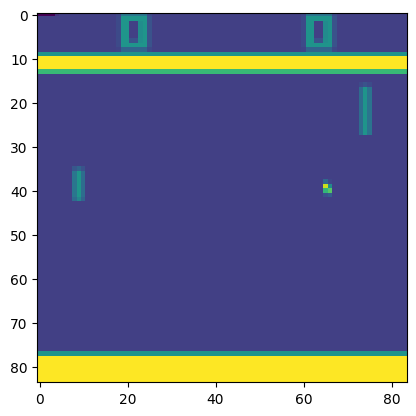

In [11]:
# GET DATA from disk
dataLoader, maxTimestep = getData('Pong', max_size=17000) # 17000*30=510000 RAM mem limit


In [12]:
#print(reward_data[:1000])
#print(rtg[:1000])
#print(timesteps[:1000])
#print(terminal_pos)
#action_data[:1000]
#print(terminal_pos)
#np.unique(action_data)

#TRAINING

In [39]:
def train(model, dataloader):

      losses = []

      optimizer = torch.optim.AdamW(model.parameters(), lr=tparams['learning_rate'], betas=tparams['betas'])

      lr = tparams['learning_rate']

      # to store the current observation and the 3 previous ones
      ob4 = torch.zeros((hparams['batch_size'], hparams['context_length'],4, 84, 84))

      counter = 0

      # TODO it's just 1 epoch, and just train_data
      for ob,ac,r,t in dataloader:
          # ob shape (batch, context_length,84, 84)

          # STACK*4 we need to stack with the 3 previous observations -> reshape(-1, 4, 84, 84)
          # TODO we have to reset ob4 in a new episode
          ob = torch.unsqueeze(ob, 2) # (batch, context_len, 1, 84, 84 )
          ob4[:,:,3,:] = ob [:,:,0,:]
          ob = ob4

          ob = ob.reshape(-1, hparams['context_length'], 4*84*84).type(torch.float32).contiguous()
          ob = ob.float().to(device)
          ac = torch.unsqueeze(ac, 2)
          ac = ac.float().to(device)
          r = torch.unsqueeze(r, 2)
          r = r.float().to(device)
          t = t[:,-1] # TODO Select the last timestep of the sequence ???
          t = torch.unsqueeze(t,1)
          t = torch.unsqueeze(t,2)
          t = t.to(device)

          model.train()
          # logits, loss = model(x, y, r)
          logits, loss = model(ob, ac, ac, r, t)
          losses.append(loss.item())

          # backprop and update the parameters
          optimizer.zero_grad()
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), tparams['grad_norm_clip'])
          optimizer.step()

          # decay the learning rate based on our progress
          #if tparams['learning_decay']:
          #    self.tokens += (y >= 0).sum() # number of tokens processed this step (i.e. label is not -100)
          #    if self.tokens < tparams['warmup_tokens']:
          #        # linear warmup
          #        lr_mult = float(self.tokens) / float(max(1, tparams['warmup_tokens']))
          #    else:
          #        # cosine learning rate decay
          #        progress = float(self.tokens - tparams['warmup_tokens']) / float(max(1, tparams['final_tokens'] - tparams['warmup_tokens']))
          #        lr_mult = max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress)))
          #    lr = tparams['learning_rate'] * lr_mult
          #    for param_group in optimizer.param_groups:
          #         param_group['lr'] = lr
          #else:
          #    lr = config.learning_rate

          # update ob4, movint channels 2-4 to 0-3 (the 4rt will be the new state)
          ob4[:,:,0:3,:] = ob4[:,:,1:4,:]

          # report progress
          counter += 1
          if (counter + 1) % 1000 == 0:
              print(f"Loss {loss.item()}")
          #  print(f"Loss ({counter+1}/{n_epochs}): {loss.item()}")

      obs_data = None
      action_data = None
      reward_data = None
      terminal_data = None
      dataset = None
      dataloader = None





In [42]:

#mconf = GPTConfig(vocab_size, hparams['block_size'],
#                  n_layer=6, n_head=8, n_embd=128, model_type=PAR_model_type, max_timestep=max(timesteps))

model_gpt = GPT(maxTimestep)
#model_gpt = GPT(3000)

train(model_gpt, dataLoader)

# token_embeddings [2, 90, 128]
# self.global_pos_emb [1, 1843, 128]
# all_global_pos_emb [2, 1843, 128]
#2_ torch.Size([2, 1, 128])
#3_ torch.Size([1, 90, 128])
# rtgs [2, 30, 1]
# states [2, 30, 28224]
# timesteps [2, 1, 1]
# token_embeddings [2, 90, 128]
# position_embeddings  [2, 90, 128]
# self.pos_emb  [1, 91, 128]

Loss 1.874470829963684
ob1_ torch.Size([2, 30, 1, 84, 84])
ob_ torch.Size([2, 30, 28224])
ac_ torch.Size([2, 30, 1])
r_ torch.Size([2, 30, 1])
t_ torch.Size([2, 1, 1])
states_in  torch.Size([2, 30, 28224])
rtgs  torch.Size([2, 30, 1])
token_embeddings  torch.Size([2, 90, 128])
token_embeddings  torch.Size([2, 90, 128])
self.global_pos_emb  torch.Size([1, 2822, 128])
all_global_pos_emb torch.Size([2, 2822, 128])
2_ torch.Size([2, 1, 128])
self.pos_emb  torch.Size([1, 91, 128])
3_ torch.Size([1, 90, 128])
token_embeddings  torch.Size([2, 90, 128])
position_embeddings  torch.Size([2, 90, 128])
logits_type  torch.float32
target_type  torch.float32
Loss 1.6566437482833862
ob1_ torch.Size([2, 30, 1, 84, 84])
ob_ torch.Size([2, 30, 28224])
ac_ torch.Size([2, 30, 1])
r_ torch.Size([2, 30, 1])
t_ torch.Size([2, 1, 1])
states_in  torch.Size([2, 30, 28224])
rtgs  torch.Size([2, 30, 1])
token_embeddings  torch.Size([2, 90, 128])
token_embeddings  torch.Size([2, 90, 128])
self.global_pos_emb  torch

KeyboardInterrupt: 

#GENERATE ACTIONS

In [39]:
def top_k_logits(logits, k):
    v, ix = torch.topk(logits, k)
    out = logits.clone()
    out[out < v[:, [-1]]] = -float('Inf')
    return out

@torch.no_grad()
def sample(model, x, steps, temperature=1.0, sample=False, top_k=None, actions=None, rtgs=None, timesteps=None):
    """
    take a conditioning sequence of indices in x (of shape (b,t)) and predict the next token in
    the sequence, feeding the predictions back into the model each time. Clearly the sampling
    has quadratic complexity unlike an RNN that is only linear, and has a finite context window
    of block_size, unlike an RNN that has an infinite context window.
    """
    block_size = model.get_block_size()
    model.eval()
    for k in range(steps):
        # x_cond = x if x.size(1) <= block_size else x[:, -block_size:] # crop context if needed
        x_cond = x if x.size(1) <= block_size//3 else x[:, -block_size//3:] # crop context if needed
        if actions is not None:
            actions = actions if actions.size(1) <= block_size//3 else actions[:, -block_size//3:] # crop context if needed
        rtgs = rtgs if rtgs.size(1) <= block_size//3 else rtgs[:, -block_size//3:] # crop context if needed
        logits, _ = model(x_cond, actions=actions, targets=None, rtgs=rtgs, timesteps=timesteps)
        # pluck the logits at the final step and scale by temperature
        logits = logits[:, -1, :] / temperature
        # optionally crop probabilities to only the top k options
        if top_k is not None:
            logits = top_k_logits(logits, top_k)
        # apply softmax to convert to probabilities
        probs = F.softmax(logits, dim=-1)
        # sample from the distribution or take the most likely
        if sample:
            ix = torch.multinomial(probs, num_samples=1)
        else:
            _, ix = torch.topk(probs, k=1, dim=-1)
        # append to the sequence and continue
        # x = torch.cat((x, ix), dim=1)
        x = ix

    return x



#GENERATE ACTIONS WITH THE MODEL

In [ ]:
!pip install "gym[accept-rom-license, atari]"

In [ ]:
import gym
#gym.envs.registration.registry.keys()

# TEST the DT with GYM

In [ ]:
env = gym.make("ALE/Breakout-v5", new_step_api=True) # start the OpenAI gym breakout environment
observation_image = env.reset() # get the image

In [ ]:
while True:

  action = env.action_space.sample()
  observation, reward, terminated, truncated, info = env.step(action)
  #print(info)

  if terminated or truncated:
      break

In [ ]:
# plot the state <observation)
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

print(observation.shape)
imgplot = plt.imshow(observation)